# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own models](#Building-own-models)
- [Evaluate results](#Evaluate-results)



In [1]:
# from google.colab import drive
# drive.mount('/content/drive') 

In [2]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'

tmpdir = tempfile.mkdtemp()


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [3]:
# !unzip drive/My\ Drive/data.zip > /dev/null

In [4]:
# /content/drive/MyDrive/Colab Notebooks/data

In [5]:
train_path = '../data/train/'
valid_path = '../data/valid/'

In [6]:
# train_path = 'data/train/'
# valid_path = 'data/valid/'

In [7]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [8]:
def get_data(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**abnormal dataset**

In [9]:
# training data
train_coronal_data, train_coronal_dir, train_ab_label = get_data('train', 'coronal', 'abnormal')
train_axial_data, train_axial_dir, train_ab_label = get_data('train', 'axial', 'abnormal')
train_sagittal_data, train_sagittal_dir, train_ab_label = get_data('train', 'sagittal', 'abnormal')

In [10]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_ab_label = get_data('valid','coronal','abnormal')
valid_axial_data, valid_axial_dir, valid_ab_label = get_data('valid','axial','abnormal')
valid_sagittal_data, valid_sagittal_dir, valid_ab_label = get_data('valid','sagittal','abnormal')

**meniscus dataset**

In [11]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [12]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [13]:
# train_coronal_men_data.remove('.DS_Store')
# train_axial_men_data.remove('.DS_Store')
# train_sagittal_men_data.remove('.DS_Store')

In [14]:
train_coronal_data[0]

'0000.npy'

In [15]:
train_coronal_dir

'../data/train//coronal'

**acl dataset**

In [16]:
# training data
train_coronal_data, train_coronal_dir, train_acl_label = get_data('train', 'coronal', 'acl')
train_axial_data, train_axial_dir, train_acl_label = get_data('train', 'axial', 'acl')
train_sagittal_data, train_sagittal_dir, train_acl_label = get_data('train', 'sagittal', 'acl')

In [17]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_acl_label = get_data('valid','coronal','acl')
valid_axial_data, valid_axial_dir, valid_acl_label = get_data('valid','axial','acl')
valid_sagittal_data, valid_sagittal_dir, valid_acl_label = get_data('valid','sagittal','acl')

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 


In [18]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
#         print(img.shape[0],middle_idx)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img_reshape = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130,256,256,3) for train
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [19]:
# image extraction for 3 planes
new_path = '../data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [20]:
new_path = '../data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [21]:
new_path = '../data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [22]:
image = np.load('../data/train_transform/sagittal.npy')

In [23]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [24]:
# image extraction for 3 planes
new_path = '../data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [25]:
new_path = '../data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [26]:
new_path = '../data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [27]:
image = np.load('../data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**normalisation intensity**

**data generation for meniscus**

In [28]:
def data_gen(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '../data/train_transform/'
    else:
        go = '../data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

Note that training data for all planes are the same. Only labels are different.

In [29]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

## Building own models

The code snippet below is the first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun built in the 1990s for image classification (with the exception of ReLU). In addition, two fully-connected layers were added, and end with a single unit and a sigmoid activation, which is perfect for a binary classification. 

In [30]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [31]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [32]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# training model that will be added to VGG16
def model_train(model, model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    path = f'{path_dir}\{model_name}\weights.h5'

    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
#             steps_per_epoch = 1096,  # len/batch_size
#             validation_steps = 116,
            verbose=1)

    model.save_weights(path)
    
    return model, history

In [33]:
def plot_results(model):
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


**predictions for meniscus dataset**

Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 6.4532 - accuracy: 0.6062 - val_loss: 0.6816 - val_accuracy: 0.5500
Epoch 2/10
36/36 [==============================] - 67s 2s/step - loss: 0.6332 - accuracy: 0.6354 - val_loss: 0.6645 - val_accuracy: 0.5833
Epoch 3/10
36/36 [==============================] - 63s 2s/step - loss: 0.6119 - accuracy: 0.6646 - val_loss: 0.6680 - val_accuracy: 0.5917
Epoch 4/10
36/36 [==============================] - 66s 2s/step - loss: 0.6040 - accuracy: 0.6761 - val_loss: 0.6747 - val_accuracy: 0.6000
Epoch 5/10
36/36 [==============================] - 60s 2s/step - loss: 0.5943 - accuracy: 0.6726 - val_loss: 0.6530 - val_accuracy: 0.6167
Epoch 6/10
36/36 [==============================] - 57s 2s/step - loss: 0.5851 - accuracy: 0.6717 - val_loss: 0.6767 - val_accuracy: 0.5917
Epoch 7/10
36/36 [==============================] - 56s 2s/step - loss: 0.5809 - accuracy: 0.6885 - val_loss: 0.6652 - val_accuracy: 0.5667
Epoch 8/10
36/36 [==

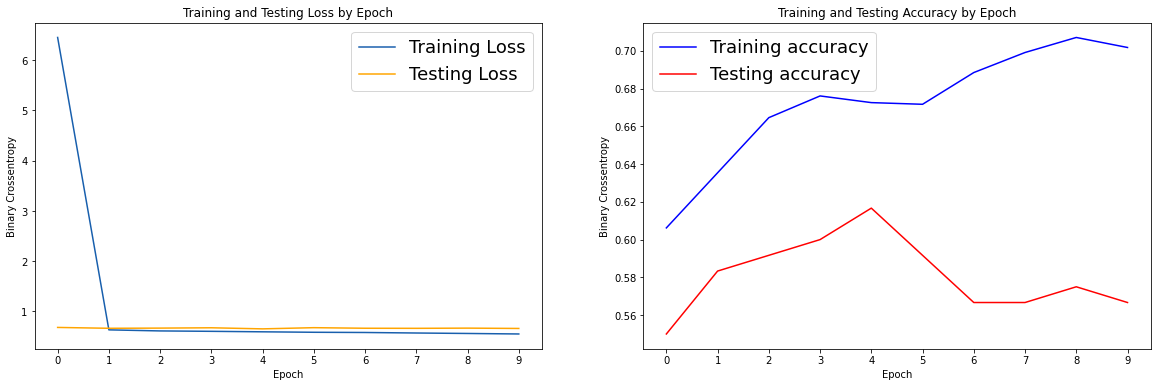

In [34]:
# coronal plane
num_epochs=10

cnn_model = build_model()
cor_men_model, hst_cmen = model_train(cnn_model, 'hst_cmen', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
hst_cmen_acc=[]
hst_cmen_acc.append(np.mean(hst_cmen.history['val_accuracy']))
plot_results(hst_cmen)

Epoch 1/10
36/36 [==============================] - 68s 2s/step - loss: 10.2595 - accuracy: 0.5743 - val_loss: 0.7056 - val_accuracy: 0.5667
Epoch 2/10
36/36 [==============================] - 63s 2s/step - loss: 0.6349 - accuracy: 0.6531 - val_loss: 0.6538 - val_accuracy: 0.6000
Epoch 3/10
36/36 [==============================] - 61s 2s/step - loss: 0.6113 - accuracy: 0.6664 - val_loss: 0.6392 - val_accuracy: 0.5917
Epoch 4/10
36/36 [==============================] - 60s 2s/step - loss: 0.5928 - accuracy: 0.6876 - val_loss: 0.6679 - val_accuracy: 0.5667
Epoch 5/10
36/36 [==============================] - 65s 2s/step - loss: 0.5837 - accuracy: 0.6823 - val_loss: 0.6478 - val_accuracy: 0.5667
Epoch 6/10
36/36 [==============================] - 68s 2s/step - loss: 0.5728 - accuracy: 0.6973 - val_loss: 0.6328 - val_accuracy: 0.6250
Epoch 7/10
36/36 [==============================] - 73s 2s/step - loss: 0.5550 - accuracy: 0.7204 - val_loss: 0.6170 - val_accuracy: 0.6417
Epoch 8/10
36/36 [=

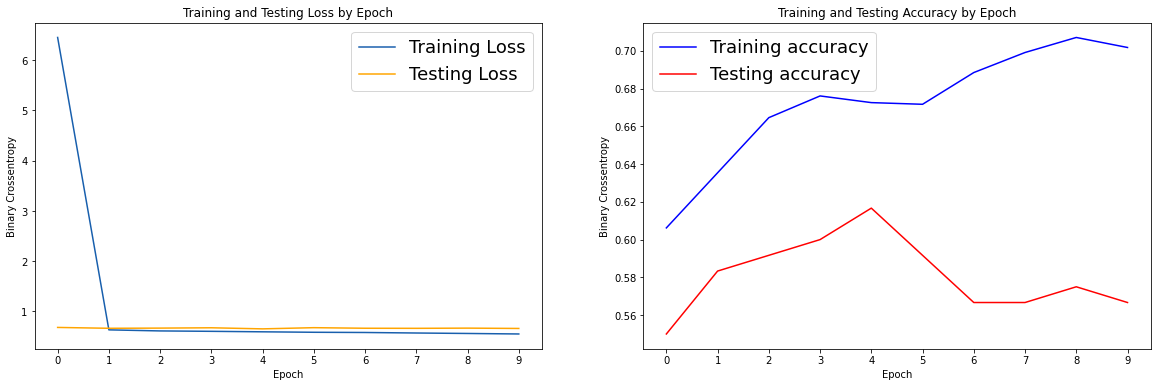

In [35]:
# axial plane
num_epochs=10

cnn_model = build_model()
axl_men_model, hst_amen = model_train(cnn_model, 'hst_amen', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
hst_amen_acc=[]
hst_amen_acc.append(np.mean(hst_amen.history['val_accuracy']))
plot_results(hst_cmen)

Epoch 1/10
36/36 [==============================] - 63s 2s/step - loss: 7.1016 - accuracy: 0.5841 - val_loss: 0.6791 - val_accuracy: 0.5333
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 0.6280 - accuracy: 0.6522 - val_loss: 0.6716 - val_accuracy: 0.5750
Epoch 3/10
36/36 [==============================] - 61s 2s/step - loss: 0.6092 - accuracy: 0.6743 - val_loss: 0.6844 - val_accuracy: 0.5917
Epoch 4/10
36/36 [==============================] - 66s 2s/step - loss: 0.5873 - accuracy: 0.6735 - val_loss: 0.6743 - val_accuracy: 0.5917
Epoch 5/10
36/36 [==============================] - 58s 2s/step - loss: 0.5825 - accuracy: 0.6912 - val_loss: 0.6862 - val_accuracy: 0.6083
Epoch 6/10
36/36 [==============================] - 60s 2s/step - loss: 0.5655 - accuracy: 0.6973 - val_loss: 0.6992 - val_accuracy: 0.6083
Epoch 7/10
36/36 [==============================] - 57s 2s/step - loss: 0.5662 - accuracy: 0.7106 - val_loss: 0.6790 - val_accuracy: 0.5917
Epoch 8/10
36/36 [==

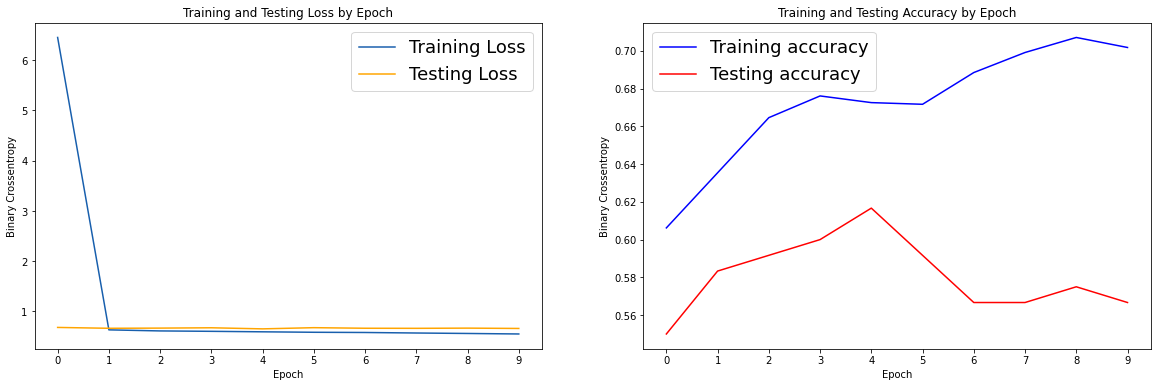

In [36]:
# sagittal plane
num_epochs=10

cnn_model = build_model()
sag_men_model, hst_smen = model_train(cnn_model, 'hst_smen', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
hst_smen_acc=[]
hst_smen_acc.append(np.mean(hst_smen.history['val_accuracy']))
plot_results(hst_cmen)

**calculate average accuracy**

In [37]:
[hst_cmen_acc, hst_amen_acc, hst_smen_acc]

[[0.5808333277702331], [0.6191666603088379], [0.5883333265781403]]

## Evaluate results

In [38]:
cmen_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.6611685156822205
Test accuracy: 0.5666666626930237


In [39]:
amen_scores = axl_men_model.evaluate(axial_mensicus_val, np.array(axial_mensicus_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.613969087600708
Test accuracy: 0.6833333373069763


In [40]:
smen_scores = sag_men_model.evaluate(sagittal_mensicus_val, np.array(sagittal_mensicus_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.6670868992805481
Test accuracy: 0.5916666388511658


**Evaluate predictions**

In [51]:
cor_pred = cor_men_model.predict(coronal_mensicus_val) 
axl_pred = axl_men_model.predict(axial_mensicus_val) 
sag_pred = sag_men_model.predict(sagittal_mensicus_val) 


In [52]:
pred = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred['mean'] = pred.mean(axis=1)

In [53]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred['mean']

0      0.119658
1      0.212153
2      0.209508
3      0.119343
4      0.499748
         ...   
115    0.408970
116    0.483480
117    0.347985
118    0.342617
119    0.250622
Name: mean, Length: 120, dtype: float32

In [54]:
# if prob<0.5, it is 0.
pred['predict'] = pred['mean'].map(lambda x: 0 if x<0.5 else 1)

In [55]:
pred['predict'].value_counts()

0    88
1    32
Name: predict, dtype: int64

In [56]:
pred['true'] = coronal_mensicus_label_val

In [59]:
pred[pred['true'] != pred['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
5,0.546926,0.433424,0.554141,0.511497,1,0
10,0.534560,0.598759,0.546162,0.559827,1,0
14,0.523339,0.753120,0.296299,0.524253,1,0
25,0.462713,0.590111,0.449014,0.500613,1,0
26,0.555102,0.707988,0.742113,0.668401,1,0
28,0.577851,0.439174,0.580093,0.532373,1,0
41,0.362948,0.616462,0.658202,0.545871,1,0
42,0.350362,0.219843,0.234657,0.268288,0,1
43,0.332641,0.401776,0.397432,0.377283,0,1
44,0.400692,0.402991,0.490782,0.431488,0,1
